In [182]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 600)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import seaborn as sns
sns.set(style='ticks', context='talk')
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.style.use('fivethirtyeight')
import pandas as pd
import numpy as np
from google.cloud import bigquery
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import gc
import xgboost as xgb
import os
import json
import functools
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.feature_extraction import DictVectorizer
my_s3_space = os.environ.get('MY_S3_SPACE')
project_id = 'talky-airship-28'
gc.enable()

In [3]:
q="""
SELECT * FROM `team-embedded-pa.tepa_days_2019.berlin_housing`"""

In [183]:
df = pd.read_csv('berlin.csv')

In [184]:
clean_amenities = ['balkon', 'keller', 'einbauküche', 'personenaufzug', 
                   'gäste-wc', 'garten', 'wg-geeignet', 'stufenlos', 
                   'wohnberechtigungsschein']

for amenity in clean_amenities:
    df['has_amenity_' + amenity] = df.amenities.apply(lambda x: 1 if amenity in str(x).lower() else 0)

In [186]:
# zipcodes clean up 
df['zipcode_clean'] = df.address_zipcode.apply(lambda x: x[:5])

# first two digits for broad region in Berlin, see https://www.google.com/search?q=zip+codes+berlin&source=lnms&tbm=isch&sa=X&ved=0ahUKEwiRktrzkMjgAhWnTBUIHRX6AwMQ_AUIDygC&biw=1280&bih=721#imgrc=7klEEvF1ffgn1M:
df['zipcode_clean_region'] = df.address_zipcode.apply(lambda x: x[:2])

In [187]:
df.head()

id                                              title  \
0  105868737                        Wohnen im Nibelungenviertel   
1   98974873  Superschöne Altbauwohnung mit Balkon, tolle La...   
2   99380618           2 Zimmer in Lankwitz/Steglitz mit Loggia   
3   94092394                                2 zimmer wohnung!!!   
4  108409035                                               TEST   

   number_of_pictures                                     address_street  \
0                2.00                                       Volkerstr. 2   
1                8.00                                        Jansastr. 9   
2               21.00                                    Leonorenstr. 18   
3                5.00  Die vollständige Adresse der Immobilie erhalte...   
4                 nan  Die vollständige Adresse der Immobilie erhalte...   

  address_zipcode                                   address_district  \
0         10365 B                          Lichtenberg (Lichtenberg)   
1         12045 B                                Neukölln (Neukölln)   
2         12247 B                                Lankwitz (Steglitz)   
3         10589 ­  Die vollständige Adresse der Immobilie erhalte...   
4      10243 test  Die vollständige Adresse der Immobilie erhalte...   

  apartment_type    floor  cold_rent  number_of_rooms  square_meters  \
0  Etagenwohnung  3 von 4     605.23             2.00          58.00   
1  Etagenwohnung  3 von 4     800.00             2.00          67.00   
2  Etagenwohnung  2 von 4     570.00             2.00          60.44   
3            NaN      NaN     500.00             2.00          55.06   
4            NaN      NaN       0.00             2.00           0.00   

                           amenities  additional_cost  heating_cost  \
0            Balkon/ Terrasse Keller            60.48     + 44,63 €   
1                             Keller            70.00         + 0 €   
2  Keller Personenaufzug Einbauküche           165.00    inkl. 60 €   
3            Balkon/ Terrasse Keller              nan  keine Angabe   
4                                NaN              nan  keine Angabe   

   total_rent deposit construction_year    apartment_condition  \
0      710.34    1815              1906                Saniert   
1      870.00   3 NKM              1907  Vollständig renoviert   
2      735.00    1710              1996               Gepflegt   
3      500.00     NaN               NaN                    NaN   
4        0.00     NaN               NaN                    NaN   

     heating_type energy_certificate energy_consumption  \
0       Fernwärme  Verbrauchsausweis                NaN   
1   Etagenheizung                NaN                NaN   
2  Zentralheizung     Bedarfsausweis              174,8   
3             NaN                NaN                NaN   
4             NaN                NaN                NaN   

                         additional_information_text  offer_date  \
0  Sanierter Altbau - aufwendig gestaltetes Grund...  03.07.2018   
1  Keine allgemeinen Sammeltermine. Bitte geben S...  09.09.2017   
2  Schöne 2 Zimmerwohnung in Berlin Lankwitz  wei...  10.11.2017   
3                                                NaN  26.03.2018   
4                                                NaN  15.11.2018   

   has_amenity_balkon  has_amenity_keller  has_amenity_einbauküche  \
0                   1                   1                        0   
1                   0                   1                        0   
2                   0                   1                        1   
3                   1                   1                        0   
4                   0                   0                        0   

   has_amenity_personenaufzug  has_amenity_gäste-wc  has_amenity_garten  \
0                           0                     0                   0   
1                           0                     0                   0   
2                           1                     

In [188]:
df.offer_date = pd.to_datetime(df.offer_date, infer_datetime_format=True)

In [189]:
df['offer_year'] = df.offer_date.dt.year
df['offer_month'] = df.offer_date.dt.month

In [190]:
df.energy_consumption.replace(',', '.', regex=True, inplace=True)

In [191]:
df.energy_consumption = pd.to_numeric(df.energy_consumption)

In [192]:
from datetime import datetime, timedelta
df['ad_age_days'] = round((pd.to_datetime(datetime.now().date()) - df['offer_date']).dt.days)

In [193]:
df.construction_year.replace('unbekannt', np.nan, regex=True, inplace=True)

In [194]:
df.construction_year = pd.to_numeric(df.construction_year)

In [195]:
df['house_age_years'] = 2019 - df.construction_year

In [196]:
df['heating_cost_additional_needed'] = np.where(df.heating_cost.str.contains('\+', regex=True), 1, 0)

In [197]:
df['heating_cost_additional'] = df['heating_cost'].str.extract('([0-9]{2,3})').fillna(0)

In [198]:
df['total_rent_calculated'] = pd.to_numeric(df.cold_rent) + pd.to_numeric(df.additional_cost) + (pd.to_numeric(df.heating_cost_additional) * pd.to_numeric(df.heating_cost_additional_needed)) 

In [199]:
# new data frame with split value columns 
new = df["address_district"].str.split("(", n = 1, expand = True) 
  
# making seperate first name column from new data frame 
df["sub_district"]= new[0] 
  
# making seperate last name column from new data frame 
df["district"]= new[1] 

# remove last bracket (ignore NaN)
df["district"]= df["district"].apply(lambda x:x[:-1] if x is not None else x)

In [202]:
# new data frame with split value columns 
new = df["floor"].str.split("von", n = 1, expand = True) if "floor" is not None else x
  
# making seperate first name column from new data frame 
df["floor_of_flat"]= new[0] 
  
# making seperate last name column from new data frame 
df["total_floors_of_house"]= new[1]

In [203]:
df.tail(2)

id                                              title  \
37694  108005162  möbliertes WG-Zimmer mit Internet, TV, Bad/Wc-...   
37695  102324581  2-Zimmer-Apartment mit Sonnenbalkon + PKW-Eins...   

       number_of_pictures      address_street  \
37694               10.00  Feldtmannstrasse 0   
37695               14.00       Spittastr. 29   

                                         address_zipcode  \
37694       13051 Berlin Weißensee (OT Hohenschönhausen)   
37695  10317 Berlin Lichtenberg Victoriastadt-Kaskelkiez   

                address_district apartment_type    floor  cold_rent  \
37694      Weißensee (Weißensee)            NaN      NaN     560.00   
37695  Lichtenberg (Lichtenberg)  Etagenwohnung  2 von 5     610.00   

       number_of_rooms  square_meters  \
37694             1.00          15.00   
37695             2.00          68.10   

                                               amenities  additional_cost  \
37694                              Garten/ -mitbenutzung             0.00   
37695  Balkon/ Terrasse Keller Personenaufzug Einbauk...           200.00   

                   heating_cost  total_rent  \
37694                 inkl. 0 €      560.00   
37695  in Nebenkosten enthalten      810.00   

                                                 deposit  construction_year  \
37694  nur 30% vom Übernachtungspreis statt 2 Monatsm...                nan   
37695                                       3 Kaltmieten            1995.00   

         apartment_condition    heating_type energy_certificate  \
37694               Gepflegt  Zentralheizung                NaN   
37695  Vollständig renoviert  Zentralheizung  Verbrauchsausweis   

       energy_consumption                        additional_information_text  \
37694                 nan  Gemütliches kleines Zimmer mit weißen Möbeln u...   
37695                 nan  Lichtdurchflutete 2-Zimmerwohnung mit Sonnenba...   

      offer_date  has_amenity_balkon  has_amenity_keller  \
37694 2018-03-11                   0                   0   
37695 2018-03-02                   1                   1   

       has_amenity_einbauküche  has_amenity_personenaufzug  \
37694                        0                           0   
37695                        1                           1   

       has_amenity_gäste-wc  has_amenity_garten  has_amenity_wg-geeignet  \
37694                     0                   1                        0   
37695                     0                   0                        0   

       has_amenity_stufenlos  has_amenity_wohnberechtigungsschein  \
37694                      0                                    0   
37695                      1                                    0   

      zipcode_clean zipcode_clean_region  offer_year  offer_month  \
37694         13051                   13        2018            3   
37695         10317                   10        2018            3   

       ad_age_days  house_age_years  heating_cost_additional_needed  \
37694          345              nan                               0   
37695          354            24.00                               0   

      heating_cost_additional  total_rent_calculated  sub_district  \
37694                       0                 560.00    Weißensee    
37695                       0                 810.00  Lichtenberg    

          district floor_of_flat total_floors_of_house  
37694    Weißensee           NaN                   NaN  
37695  Lichtenberg            2                      5

In [204]:
df.describe()

id  number_of_pictures  cold_rent  number_of_rooms  \
count     37696.00            37047.00   37694.00         37694.00   
mean  100686431.11               11.15    1007.50             2.48   
std     9515741.29                6.76    6613.82             1.50   
min    30247283.00                1.00       0.00             1.00   
25%    96738716.75                7.00     536.46             2.00   
50%   103057545.50               10.00     744.60             2.00   
75%   107198343.00               14.00    1140.00             3.00   
max   109862750.00               87.00 1000000.00           200.00   

       square_meters  additional_cost  total_rent  construction_year  \
count       37694.00         37064.00    37694.00           33726.00   
mean           78.33           170.31     1197.76            1954.83   
std           171.19           125.80     5770.68              47.72   
min             0.00             0.00        0.00            1016.00   
25%            53.25            95.17      680.00            1908.00   
50%            68.20           138.97      921.70            1961.00   
75%            91.00           204.00     1374.00            1997.00   
max         31787.00          3800.00  1000000.00            2019.00   

       energy_consumption  has_amenity_balkon  has_amenity_keller  \
count            11725.00            37696.00            37696.00   
mean               111.83                0.71                0.54   
std                 69.26                0.46                0.50   
min                  0.46                0.00                0.00   
25%                 65.80                0.00                0.00   
50%                 97.00                1.00                1.00   
75%                145.00                1.00                1.00   
max               1614.10                1.00                1.00   

       has_amenity_einbauküche  has_amenity_personenaufzug  \
count                 37696.00                    37696.00   
mean                      0.51                        0.41   
std                       0.50                        0.49   
min                       0.00                        0.00   
25%                       0.00                        0.00   
50%                       1.00                        0.00   
75%                       1.00                        1.00   
max                       1.00                        1.00   

       has_amenity_gäste-wc  has_amenity_garten  has_amenity_wg-geeignet  \
count              37696.00            37696.00                 37696.00   
mean                   0.16                0.11                     0.10   
std                    0.37                0.31                     0.30   
min                    0.00                0.00                     0.00   
25%                    0.00                0.00                     0.00   
50%                    0.00                0.00                     0.00   
75%                    0.00                0.00                     0.00   
max                    1.00                1.00                     1.00   

       has_amenity_stufenlos  has_amenity_wohnberechtigungsschein  offer_year  \
count               37696.00                             37696.00    37696.00   
mean                    0.10                                 0.06     2017.82   
std                     0.30                                 0.24        0.70   
min                     0.00                                 0.00     2017.00   
25%                     0.00                                 0.00     2017.00   
50%                     0.00                                 0.00     2018.00   
75%                     0.00                                 0.00     2018.00   
max                     1.00                                 1.00     2019.00   

       offer_month  ad_age_days  house_age_years  \
count     37696.00     37696.00         33726.00   
mean          6.08       310.22     

In [ ]:
df.head()

In [209]:
q_lower = df.total_rent_calculated.quantile(0.001)

In [210]:
q_higher = df.total_rent_calculated.quantile(0.999)

In [211]:
df = df[(df.total_rent_calculated < q_higher) & (df.total_rent_calculated > q_lower)]

In [212]:
df.describe()

id  number_of_pictures  cold_rent  number_of_rooms  \
count     36988.00            36366.00   36988.00         36988.00   
mean  100665393.13               11.14     932.46             2.48   
std     9530183.18                6.77     622.83             1.05   
min    30247283.00                1.00       0.00             1.00   
25%    96727749.50                7.00     537.55             2.00   
50%   103034094.50               10.00     743.00             2.00   
75%   107190938.00               14.00    1130.00             3.00   
max   109862750.00               87.00    6300.00            15.00   

       square_meters  additional_cost  total_rent  construction_year  \
count       36988.00         36988.00    36988.00           33287.00   
mean           78.11           169.20     1151.34            1954.76   
std           171.96           115.90     1478.48              47.72   
min             0.00             0.00        0.00            1016.00   
25%            53.35            95.44      683.00            1908.00   
50%            68.21           138.94      922.00            1961.00   
75%            91.00           203.49     1370.00            1996.00   
max         31787.00          3000.00   210191.00            2019.00   

       energy_consumption  has_amenity_balkon  has_amenity_keller  \
count            11588.00            36988.00            36988.00   
mean               111.89                0.71                0.54   
std                 68.64                0.46                0.50   
min                  0.46                0.00                0.00   
25%                 65.80                0.00                0.00   
50%                 97.50                1.00                1.00   
75%                145.00                1.00                1.00   
max               1614.10                1.00                1.00   

       has_amenity_einbauküche  has_amenity_personenaufzug  \
count                 36988.00                    36988.00   
mean                      0.51                        0.41   
std                       0.50                        0.49   
min                       0.00                        0.00   
25%                       0.00                        0.00   
50%                       1.00                        0.00   
75%                       1.00                        1.00   
max                       1.00                        1.00   

       has_amenity_gäste-wc  has_amenity_garten  has_amenity_wg-geeignet  \
count              36988.00            36988.00                 36988.00   
mean                   0.16                0.11                     0.10   
std                    0.37                0.31                     0.30   
min                    0.00                0.00                     0.00   
25%                    0.00                0.00                     0.00   
50%                    0.00                0.00                     0.00   
75%                    0.00                0.00                     0.00   
max                    1.00                1.00                     1.00   

       has_amenity_stufenlos  has_amenity_wohnberechtigungsschein  offer_year  \
count               36988.00                             36988.00    36988.00   
mean                    0.10                                 0.06     2017.82   
std                     0.30                                 0.24        0.70   
min                     0.00                                 0.00     2017.00   
25%                     0.00                                 0.00     2017.00   
50%                     0.00                                 0.00     2018.00   
75%                     0.00                                 0.00     2018.00   
max                     1.00                                 1.00     2019.00   

       offer_month  ad_age_days  house_age_years  \
count     36988.00     36988.00         33287.00   
mean          6.08       310.89     

In [213]:
def convert_types(df):
    """Convert pandas data types for memory reduction."""
    
    # Iterate through each column
    for c in df:
        
        # Convert numpy arrays to categoricals
#         if (df[c].dtype == 'O'):
#             df[c] = df[c].apply(lambda x: np.array2string(x)).astype('category')
            
#       Convert objects to str so the file can be saved as parquet if needed
        if (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
             df[c] = df[c].astype('str')
        
        # Booleans mapped to integers
        elif set(df[c].unique()) == {0, 1}:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
    return df

In [214]:
df = convert_types(df)

In [217]:
df.sort_values(by='offer_date', ascending=True, inplace=True)

In [309]:
df['floor_of_flat'] = pd.to_numeric(df['floor_of_flat'], errors='coerce')
df['total_floors_of_house'] = pd.to_numeric(df['total_floors_of_house'], errors='coerce')

In [310]:
df['pictures_per_room'] = df['number_of_pictures'] / df['number_of_rooms']
df['avg_size_per_room'] = df['square_meters'] / df['number_of_rooms']
df['floor_location'] = df['floor_of_flat'] / df['total_floors_of_house']

In [313]:
correlations = pd.DataFrame(df.corr()['total_rent_calculated'])

In [317]:
correlations.sort_values(by='total_rent_calculated', ascending=False)

total_rent_calculated
total_rent_calculated                                 1.00
cold_rent                                             0.99
additional_cost                                       0.80
number_of_rooms                                       0.68
has_amenity_gäste-wc                                  0.57
total_rent                                            0.49
number_of_pictures                                    0.38
has_amenity_personenaufzug                            0.28
has_amenity_einbauküche                               0.27
has_amenity_stufenlos                                 0.22
has_amenity_balkon                                    0.21
square_meters                                         0.19
has_amenity_keller                                    0.16
floor_location                                        0.15
has_amenity_garten                                    0.12
floor_of_flat                                         0.11
construction_year                                     0.08
has_amenity_wg-geeignet                               0.05
avg_size_per_room                                     0.03
id                                                    0.03
offer_year                                            0.02
ad_age_days                                          -0.00
total_floors_of_house                                -0.01
offer_month                                          -0.04
house_age_years                                      -0.08
pictures_per_room                                    -0.10
heating_cost_additional_needed                       -0.16
energy_consumption                                   -0.18
has_amenity_wohnberechtigungsschein                  -0.19

In [318]:
y = df['total_rent_calculated']
X = df.drop(['total_rent', 'total_rent_calculated', 'cold_rent', 'additional_cost', 'heating_cost', 'deposit', 'id', 'title','address_street', 'address_zipcode', 'address_district', 'floor', 'amenities', 'additional_information_text', 'offer_date', 'heating_cost_additional', 'heating_cost_additional_needed' ], axis=1)

In [319]:
#Label encode categoricals
for c in X.columns:
    if X[c].dtype == 'object':
        lbl = LabelEncoder() 
        lbl.fit(list(X[c].values)) 
        X[c] = lbl.transform(list(X[c].values))

In [320]:
t_size = 0.8
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=t_size, random_state=90, shuffle=True)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [321]:
X_train, X_validation = convert_types(X_train), convert_types(X_validation)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [322]:
X_train.head()

number_of_pictures  apartment_type  number_of_rooms  square_meters  \
22046                3.00               1             2.00          47.89   
14721                1.00               2             2.00          59.00   
34915               15.00              10             3.00         183.00   
19396                1.00               7             2.00          53.01   
36586                3.00               2             3.50         158.00   

       construction_year  apartment_condition  heating_type  \
22046            1997.00                    2            12   
14721            1900.00                    3            11   
34915                nan                    8            11   
19396            1929.00                    2            11   
36586                nan                    9            12   

       energy_certificate  energy_consumption  has_amenity_balkon  \
22046                   1                 nan                True   
14721                   0              162.90               False   
34915                   2                 nan               False   
19396                   1                 nan                True   
36586                   2                 nan                True   

       has_amenity_keller  has_amenity_einbauküche  \
22046                True                     True   
14721               False                    False   
34915                True                     True   
19396                True                    False   
36586               False                    False   

       has_amenity_personenaufzug  has_amenity_gäste-wc  has_amenity_garten  \
22046                       False                 False               False   
14721                       False                 False               False   
34915                       False                  True               False   
19396                       False                 False               False   
36586                       False                 False               False   

       has_amenity_wg-geeignet  has_amenity_stufenlos  \
22046                    False                  False   
14721                    False                  False   
34915                    False                  False   
19396                    False                  False   
36586                    False                  False   

       has_amenity_wohnberechtigungsschein  zipcode_clean  \
22046                                False            134   
14721                                False             76   
34915                                False            233   
19396                                False            115   
36586                                False            229   

       zipcode_clean_region  offer_year  offer_month  ad_age_days  \
22046                     2        2017            9          529   
14721                     0        2018            4          298   
34915                     4        2018            2          356   
19396                     2        2017            2          744   
36586                     4        2018            5          264   

       house_age_years  sub_district  district  floor_of_flat  \
22046            22.00             4        21            nan   
14721           119.00            43         6           4.00   
34915              nan            17        12            nan   
19396            90.00            10        11           2.00   
36586              nan            17        12           1.00   

       total_floors_of_house  pictures_per_room  avg_size_per_room  \
22046                    nan               1.50              23.94   
14721                   4.00               0.50              29.50   
34915                    nan               5.00              61.00   
19396                   5.00               0.50              26.50   
36586                    nan               0.86              45.14   

       floor_

In [282]:
len(X_train), len(X_validation), len(y_train)

(29590, 7398, 29590)

In [326]:
params = {'eta': 0.1,
          'max_depth': 7, 
          'subsample': 0.8, 
          'colsample_bytree': 0.7, 
          'objective': 'reg:linear', 
          'random_state': 99,
          'silent': True}

In [324]:
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_validation, y_validation)

gc.collect()
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [327]:
model = xgb.train(params, dtrain, 2000, watchlist, maximize=False, early_stopping_rounds = 50, verbose_eval=True)

[0]	train-rmse:1223.69	valid-rmse:1197.51
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[1]	train-rmse:1107.36	valid-rmse:1082.74
[2]	train-rmse:1003.59	valid-rmse:980.461
[3]	train-rmse:910.106	valid-rmse:888.673
[4]	train-rmse:831.85	valid-rmse:811.997
[5]	train-rmse:761.82	valid-rmse:742.913
[6]	train-rmse:693.103	valid-rmse:675.78
[7]	train-rmse:631.519	valid-rmse:615.868
[8]	train-rmse:576.444	valid-rmse:562.768
[9]	train-rmse:527.283	valid-rmse:515.065
[10]	train-rmse:483.167	valid-rmse:472.173
[11]	train-rmse:443.799	valid-rmse:434.742
[12]	train-rmse:409.326	valid-rmse:402.293
[13]	train-rmse:380.747	valid-rmse:375.604
[14]	train-rmse:352.882	valid-rmse:349.49
[15]	train-rmse:329.288	valid-rmse:327.14
[16]	train-rmse:307.128	valid-rmse:306.8
[17]	train-rmse:288.193	valid-rmse:289.717
[18]	train-rmse:270.765	valid-rmse:274.221
[19]	train-rmse:255.987	valid-rmse:261.557
[20]	train-r

[187]	train-rmse:103.804	valid-rmse:164.355
[188]	train-rmse:103.778	valid-rmse:164.349
[189]	train-rmse:103.597	valid-rmse:164.298
[190]	train-rmse:103.252	valid-rmse:164.203
[191]	train-rmse:103.211	valid-rmse:164.213
[192]	train-rmse:103.056	valid-rmse:164.18
[193]	train-rmse:102.907	valid-rmse:164.127
[194]	train-rmse:102.684	valid-rmse:164.124
[195]	train-rmse:102.5	valid-rmse:164.086
[196]	train-rmse:102.363	valid-rmse:164.027
[197]	train-rmse:102.184	valid-rmse:163.933
[198]	train-rmse:101.987	valid-rmse:163.89
[199]	train-rmse:101.796	valid-rmse:163.831
[200]	train-rmse:101.552	valid-rmse:163.786
[201]	train-rmse:101.21	valid-rmse:163.737
[202]	train-rmse:101.124	valid-rmse:163.705
[203]	train-rmse:100.965	valid-rmse:163.668
[204]	train-rmse:100.579	valid-rmse:163.677
[205]	train-rmse:100.448	valid-rmse:163.65
[206]	train-rmse:100.223	valid-rmse:163.612
[207]	train-rmse:100.074	valid-rmse:163.563
[208]	train-rmse:99.9948	valid-rmse:163.559
[209]	train-rmse:99.8217	valid-rmse:16

[375]	train-rmse:77.1166	valid-rmse:159.912
[376]	train-rmse:76.9907	valid-rmse:159.873
[377]	train-rmse:76.8662	valid-rmse:159.876
[378]	train-rmse:76.7359	valid-rmse:159.875
[379]	train-rmse:76.62	valid-rmse:159.849
[380]	train-rmse:76.5215	valid-rmse:159.83
[381]	train-rmse:76.4888	valid-rmse:159.844
[382]	train-rmse:76.4527	valid-rmse:159.845
[383]	train-rmse:76.2473	valid-rmse:159.841
[384]	train-rmse:76.1675	valid-rmse:159.829
[385]	train-rmse:76.0641	valid-rmse:159.814
[386]	train-rmse:75.9713	valid-rmse:159.787
[387]	train-rmse:75.8977	valid-rmse:159.769
[388]	train-rmse:75.7834	valid-rmse:159.75
[389]	train-rmse:75.7187	valid-rmse:159.741
[390]	train-rmse:75.562	valid-rmse:159.733
[391]	train-rmse:75.4612	valid-rmse:159.711
[392]	train-rmse:75.3385	valid-rmse:159.718
[393]	train-rmse:75.1936	valid-rmse:159.686
[394]	train-rmse:75.1463	valid-rmse:159.673
[395]	train-rmse:74.9406	valid-rmse:159.606
[396]	train-rmse:74.7942	valid-rmse:159.58
[397]	train-rmse:74.662	valid-rmse:159

[563]	train-rmse:60.0548	valid-rmse:158.293
[564]	train-rmse:59.9764	valid-rmse:158.301
[565]	train-rmse:59.9456	valid-rmse:158.291
[566]	train-rmse:59.8816	valid-rmse:158.298
[567]	train-rmse:59.8132	valid-rmse:158.291
[568]	train-rmse:59.715	valid-rmse:158.258
[569]	train-rmse:59.6487	valid-rmse:158.228
[570]	train-rmse:59.5998	valid-rmse:158.217
[571]	train-rmse:59.5411	valid-rmse:158.212
[572]	train-rmse:59.4739	valid-rmse:158.212
[573]	train-rmse:59.4452	valid-rmse:158.211
[574]	train-rmse:59.3178	valid-rmse:158.208
[575]	train-rmse:59.2389	valid-rmse:158.189
[576]	train-rmse:59.1911	valid-rmse:158.201
[577]	train-rmse:59.0636	valid-rmse:158.225
[578]	train-rmse:58.9536	valid-rmse:158.214
[579]	train-rmse:58.8854	valid-rmse:158.189
[580]	train-rmse:58.8254	valid-rmse:158.196
[581]	train-rmse:58.7662	valid-rmse:158.189
[582]	train-rmse:58.6903	valid-rmse:158.186
[583]	train-rmse:58.6017	valid-rmse:158.162
[584]	train-rmse:58.5151	valid-rmse:158.147
[585]	train-rmse:58.4167	valid-rm

[751]	train-rmse:48.0319	valid-rmse:157.421
[752]	train-rmse:47.9558	valid-rmse:157.404
[753]	train-rmse:47.8933	valid-rmse:157.406
[754]	train-rmse:47.8243	valid-rmse:157.415
[755]	train-rmse:47.7768	valid-rmse:157.421
[756]	train-rmse:47.7196	valid-rmse:157.426
[757]	train-rmse:47.6563	valid-rmse:157.416
[758]	train-rmse:47.6004	valid-rmse:157.409
[759]	train-rmse:47.5775	valid-rmse:157.395
[760]	train-rmse:47.5113	valid-rmse:157.402
[761]	train-rmse:47.3878	valid-rmse:157.385
[762]	train-rmse:47.3172	valid-rmse:157.37
[763]	train-rmse:47.2765	valid-rmse:157.373
[764]	train-rmse:47.1759	valid-rmse:157.386
[765]	train-rmse:47.1469	valid-rmse:157.393
[766]	train-rmse:47.0849	valid-rmse:157.38
[767]	train-rmse:47.0318	valid-rmse:157.376
[768]	train-rmse:46.9876	valid-rmse:157.38
[769]	train-rmse:46.9396	valid-rmse:157.377
[770]	train-rmse:46.8683	valid-rmse:157.362
[771]	train-rmse:46.828	valid-rmse:157.359
[772]	train-rmse:46.7671	valid-rmse:157.337
[773]	train-rmse:46.6968	valid-rmse:

[939]	train-rmse:38.8593	valid-rmse:157.04
[940]	train-rmse:38.8056	valid-rmse:157.036
[941]	train-rmse:38.7553	valid-rmse:157.032
[942]	train-rmse:38.6973	valid-rmse:157.028
[943]	train-rmse:38.6569	valid-rmse:157.017
[944]	train-rmse:38.641	valid-rmse:157.017
[945]	train-rmse:38.6224	valid-rmse:157.013
[946]	train-rmse:38.5808	valid-rmse:157.017
[947]	train-rmse:38.4972	valid-rmse:157.004
[948]	train-rmse:38.4465	valid-rmse:157.01
[949]	train-rmse:38.3988	valid-rmse:157.002
[950]	train-rmse:38.346	valid-rmse:157.01
[951]	train-rmse:38.3115	valid-rmse:157.007
[952]	train-rmse:38.2623	valid-rmse:157.009
[953]	train-rmse:38.2312	valid-rmse:157.011
[954]	train-rmse:38.2155	valid-rmse:157.01
Stopping. Best iteration:
[904]	train-rmse:40.3993	valid-rmse:156.998



In [328]:
y_pred = model.predict(dvalid)

In [287]:
y_pred

array([ 835.3419,  509.3701, 1009.2536, ...,  853.3816,  712.2138,
       1209.8605], dtype=float32)

In [252]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

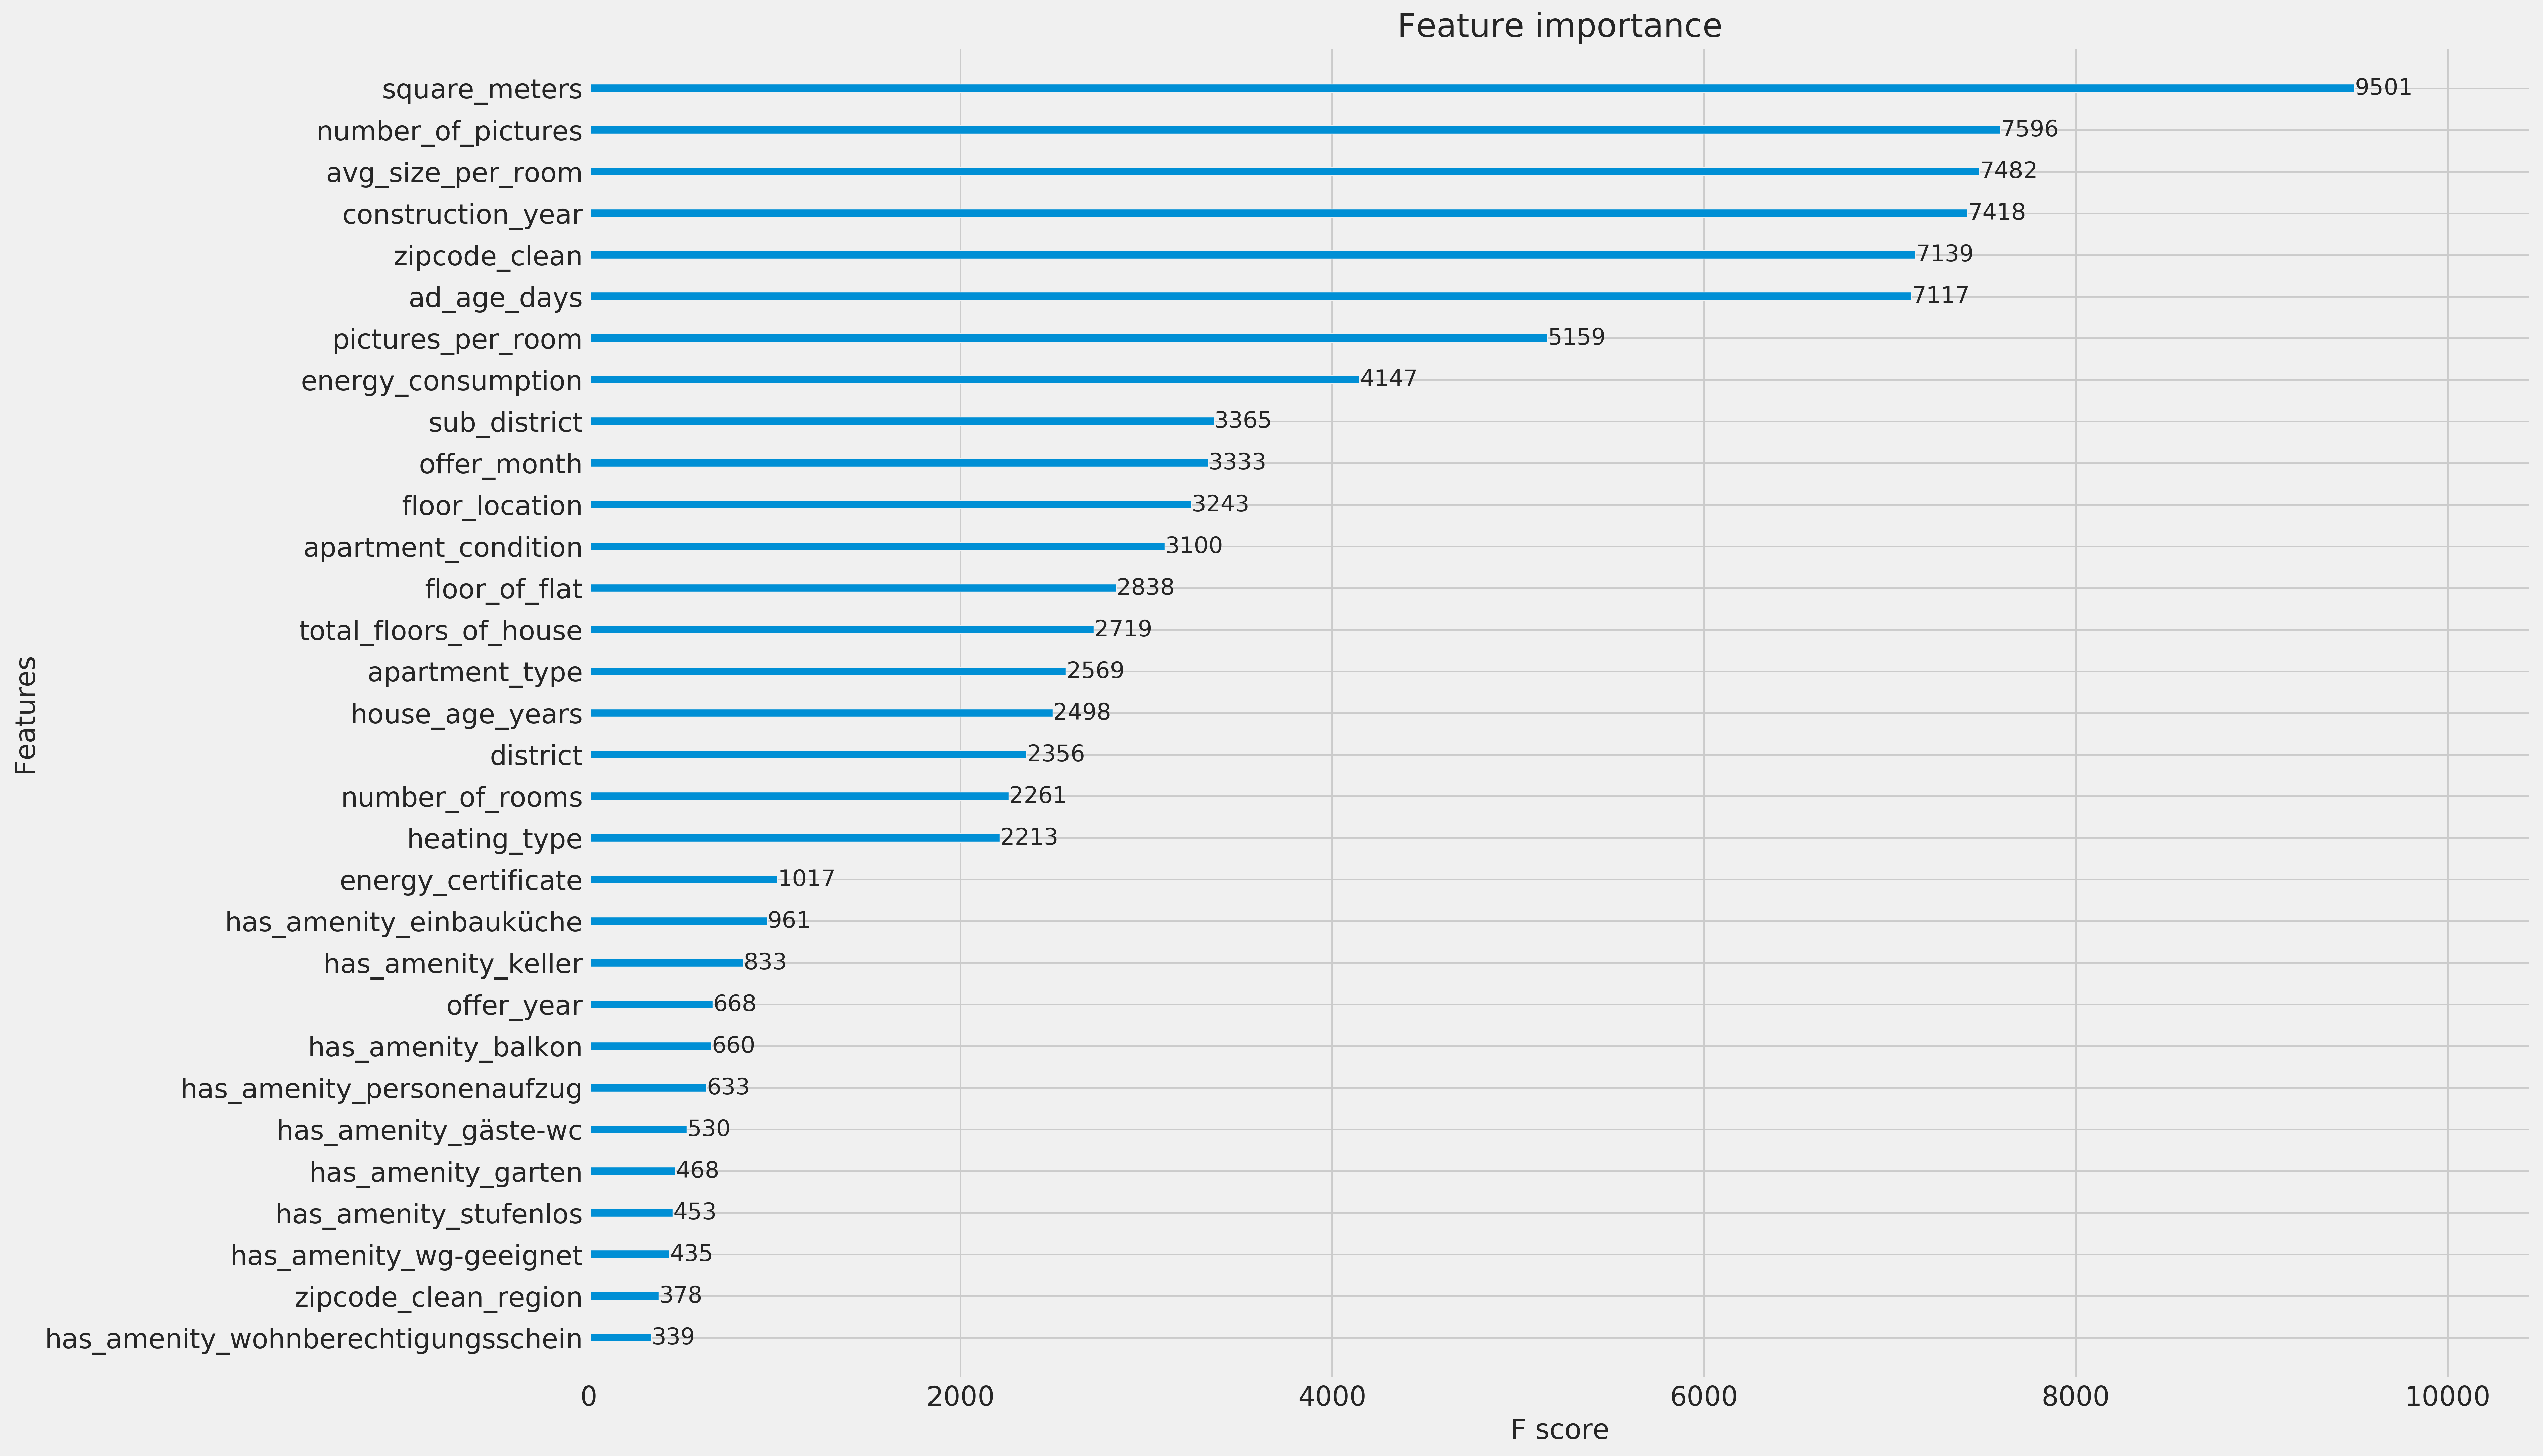

In [329]:
fig, ax = plt.subplots(figsize=(19, 14), dpi=350)
from xgboost import plot_importance
plot_importance(model, ax=ax, max_num_features=40)
#fig.savefig('importance.png', bbox_inches='tight')

In [263]:
mae= mean_absolute_error(y_validation, y_pred)
msq = mean_squared_error(y_validation, y_pred)
r2 = r2_score(y_validation, y_pred)
mean_deviation = mae / y.mean()
f"MAE is: {mae}", f"MSE is: {msq}", f"R2 is: {r2}", f"Mean deviation is: {mean_deviation}"

('MAE is: 136.09498596191406',
 'MSE is: 53429.6484375',
 'R2 is: 0.9019331800683295',
 'Mean deviation is: 0.1196194508808078')

In [330]:
mae= mean_absolute_error(y_validation, y_pred)
msq = mean_squared_error(y_validation, y_pred)
r2 = r2_score(y_validation, y_pred)
mean_deviation = mae / y.mean()
f"MAE is: {mae}", f"MSE is: {msq}", f"R2 is: {r2}", f"Mean deviation is: {mean_deviation}"

('MAE is: 89.02549743652344',
 'MSE is: 24652.16796875',
 'R2 is: 0.9489916994211186',
 'Mean deviation is: 0.07824815177781679')

In [331]:
predictors = list(X_train.columns)
categorical_features = list(np.where(X_train.dtypes == int)[0])

In [332]:
xgtrain = lgb.Dataset(X_train.values, label=y_train.values,feature_name=predictors, categorical_feature=categorical_features)
xgvalid = lgb.Dataset(X_validation.values, label=y_validation.values,feature_name=predictors, categorical_feature=categorical_features)                         

In [333]:
lgb_params = {
        'boosting_type': 'gbdt',
        'metric':'rmse',
        'learning_rate': 0.1,
        
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
       # 'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
       # 'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.8,  # Subsample ratio of the training instance.
        #'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
        'verbose': 0}

In [334]:
evals_results = {}

bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=3000,
                     early_stopping_rounds=50,
                     verbose_eval=10)
n_estimators = bst1.best_iteration


print("\nModel Report")
print("n_estimators : ", n_estimators)
print('auc'+":", evals_results['valid']['auc'][n_estimators-1])

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds.
[10]	train's rmse: 364.521	valid's rmse: 353.196
[20]	train's rmse: 244.798	valid's rmse: 248.193
[30]	train's rmse: 207.206	valid's rmse: 219.017
[40]	train's rmse: 190.063	valid's rmse: 205.453
[50]	train's rmse: 180.04	valid's rmse: 198.296
[60]	train's rmse: 172.749	valid's rmse: 193.302
[70]	train's rmse: 167.213	valid's rmse: 190.091
[80]	train's rmse: 162.862	valid's rmse: 187.471
[90]	train's rmse: 158.832	valid's rmse: 185.031
[100]	train's rmse: 155.464	valid's rmse: 183.373
[110]	train's rmse: 152.621	valid's rmse: 181.922
[120]	train's rmse: 149.802	valid's rmse: 180.774
[130]	train's rmse: 147.294	valid's rmse: 180.182
[140]	train's rmse: 145.179	valid's rmse: 179.138
[150]	train's rmse: 143.13	valid's rmse: 178.176
[160]	train's rmse: 141.155	valid's rmse: 177.466
[170]	train's rmse: 139.231	valid's rmse: 176.592
[180]	train's rmse: 137.56	valid's rmse: 175.811
[190]	train's rmse: 135.92	valid's rmse: 175.188
[

[1640]	train's rmse: 59.1667	valid's rmse: 159.878
[1650]	train's rmse: 58.9244	valid's rmse: 159.868
[1660]	train's rmse: 58.6262	valid's rmse: 159.863
[1670]	train's rmse: 58.4144	valid's rmse: 159.862
[1680]	train's rmse: 58.145	valid's rmse: 159.835
[1690]	train's rmse: 57.8845	valid's rmse: 159.821
[1700]	train's rmse: 57.6803	valid's rmse: 159.785
[1710]	train's rmse: 57.415	valid's rmse: 159.779
[1720]	train's rmse: 57.1388	valid's rmse: 159.776
[1730]	train's rmse: 56.9362	valid's rmse: 159.761
[1740]	train's rmse: 56.6793	valid's rmse: 159.724
[1750]	train's rmse: 56.4903	valid's rmse: 159.706
[1760]	train's rmse: 56.2865	valid's rmse: 159.68
[1770]	train's rmse: 56.0903	valid's rmse: 159.633
[1780]	train's rmse: 55.892	valid's rmse: 159.637
[1790]	train's rmse: 55.6488	valid's rmse: 159.623
[1800]	train's rmse: 55.4546	valid's rmse: 159.605
[1810]	train's rmse: 55.1184	valid's rmse: 159.591
[1820]	train's rmse: 54.8496	valid's rmse: 159.584
[1830]	train's rmse: 54.6264	valid'

IndexError: list index out of range

In [335]:
y_pred = bst1.predict(X_validation.values, n_estimators=n_estimators)

In [336]:
mae= mean_absolute_error(y_validation, y_pred)
msq = mean_squared_error(y_validation, y_pred)
r2 = r2_score(y_validation, y_pred)
mean_deviation = mae / y.mean()
f"MAE is: {mae}", f"MSE is: {msq}", f"R2 is: {r2}", f"Mean deviation is: {mean_deviation}"

('MAE is: 88.67977279209282',
 'MSE is: 25277.237692244507',
 'R2 is: 0.9476983548957342',
 'Mean deviation is: 0.07794428024404605')

In [337]:
importance = pd.DataFrame(bst1.feature_importance(importance_type='gain', iteration=None), index=bst1.feature_name(), columns=['Feature Importance']).sort_values(ascending=False, by='Feature Importance')

In [338]:
importance

Feature Importance
square_meters                            43446529641.87
has_amenity_gäste-wc                      9498350687.10
number_of_rooms                           6197114310.96
avg_size_per_room                         5174022978.03
zipcode_clean                             3680512248.80
construction_year                         1637753179.85
apartment_condition                       1409793660.64
number_of_pictures                        1068365734.98
energy_consumption                         940646802.21
has_amenity_personenaufzug                 939819135.86
pictures_per_room                          932527021.76
has_amenity_einbauküche                    873492166.42
house_age_years                            807092847.97
sub_district                               772506485.33
zipcode_clean_region                       738364702.43
ad_age_days                                539334156.51
has_amenity_wohnberechtigungsschein        528775324.71
floor_of_flat                              450599408.58
district                                   410249276.73
total_floors_of_house                      346678999.20
floor_location                             292996567.52
apartment_type                             226242201.48
heating_type                               210082443.09
offer_month                                124677719.38
has_amenity_stufenlos                      110830609.03
offer_year                                  83125038.26
energy_certificate                          83124630.70
has_amenity_keller                          61686500.20
has_amenity_garten                          22135989.66
has_amenity_balkon                          21251998.44
has_amenity_wg-geeignet                     18826071.43

In [299]:
X_plots = df.drop(['total_rent', 'cold_rent', 'additional_cost', 'heating_cost', 'deposit', 'id', 'title','address_street', 'address_zipcode', 'address_district', 'floor', 'amenities', 'additional_information_text', 'offer_date', 'heating_cost_additional', 'heating_cost_additional_needed' ], axis=1)

In [300]:
t_size = 0.8
X_train, X_validation= train_test_split(X_plots, train_size=t_size, random_state=90, shuffle=True)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


                                     Plots for number_of_pictures                                     
                                           Train data plots                                           


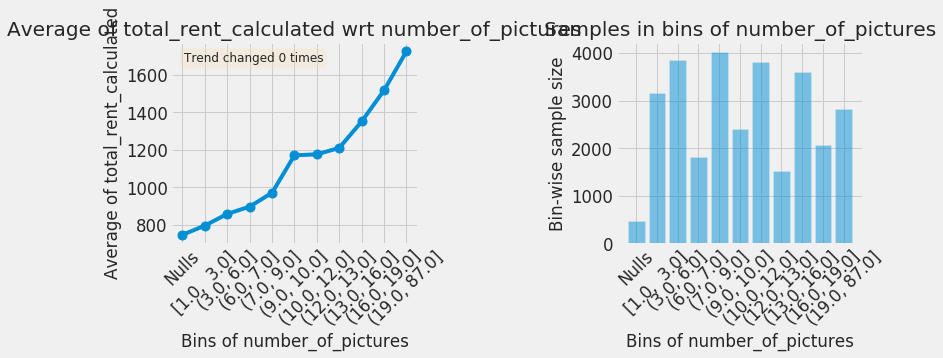

                                           Test data plots                                            


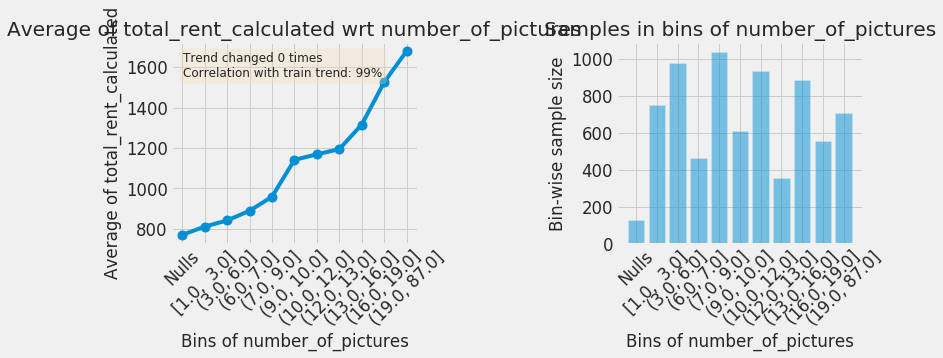

--------------------------------------------------------------------------------------------------------------


apartment_type is categorical. Categorical features not supported yet.
                                      Plots for number_of_rooms                                       
                                           Train data plots                                           


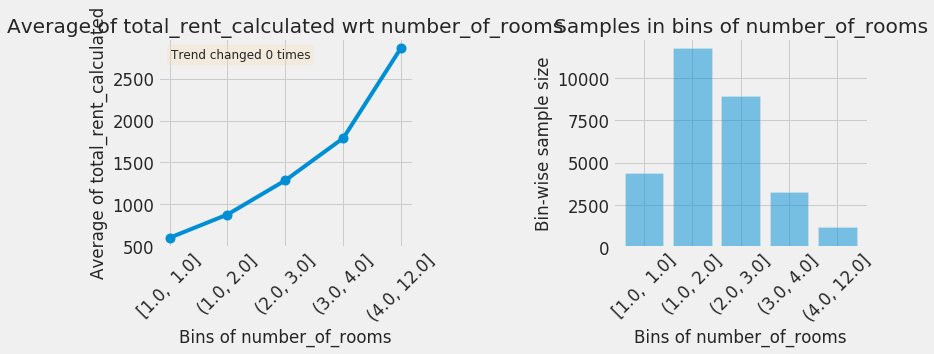

                                           Test data plots                                            


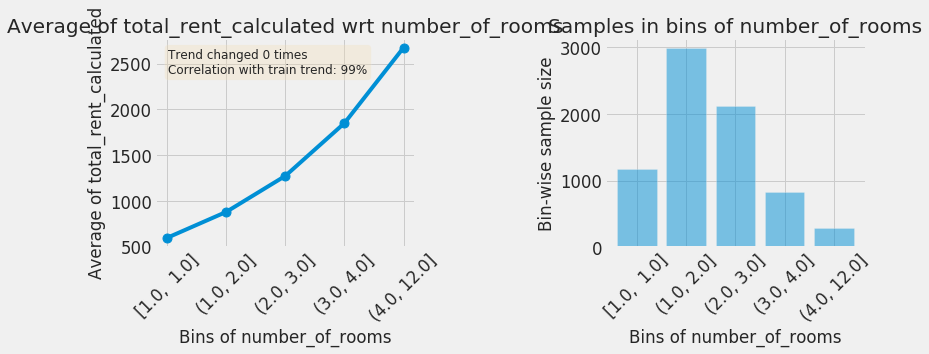

--------------------------------------------------------------------------------------------------------------


                                       Plots for square_meters                                        
                                           Train data plots                                           


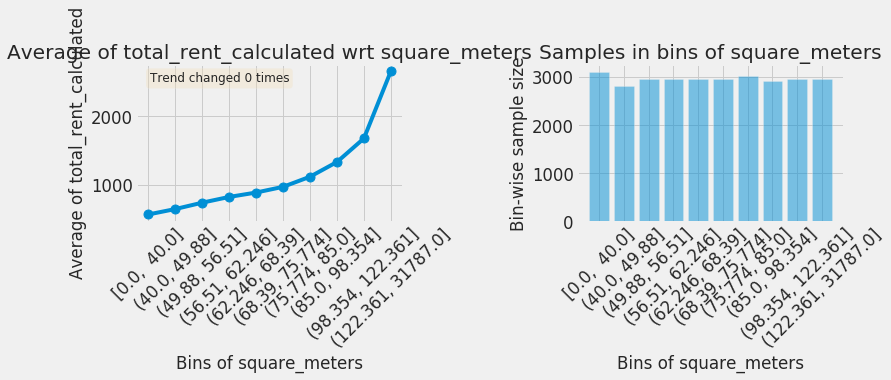

                                           Test data plots                                            


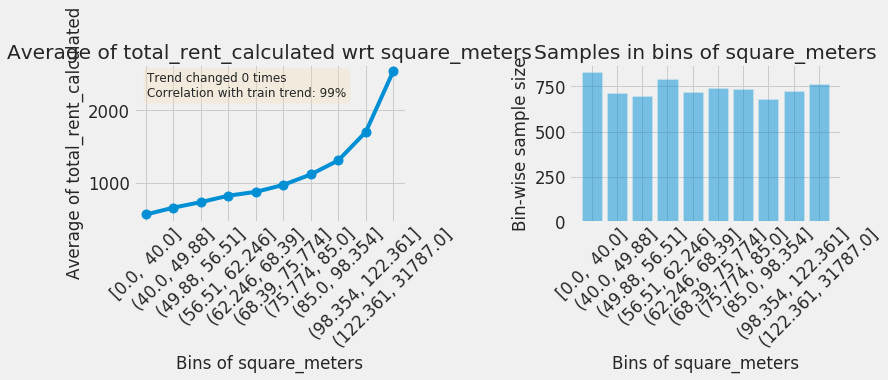

--------------------------------------------------------------------------------------------------------------


                                     Plots for construction_year                                      
                                           Train data plots                                           


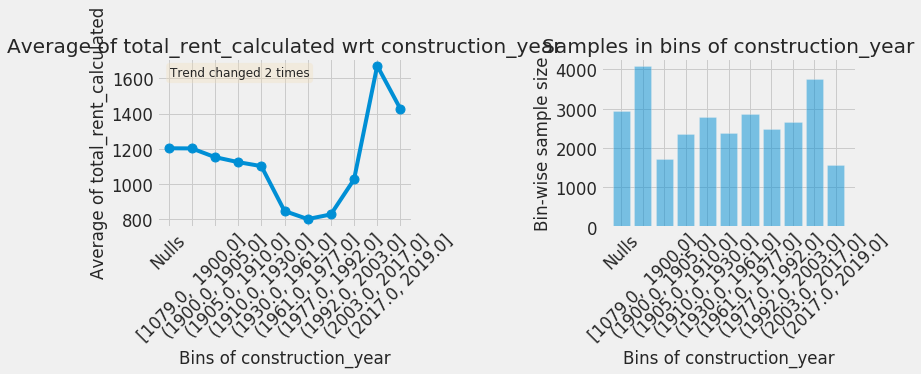

                                           Test data plots                                            


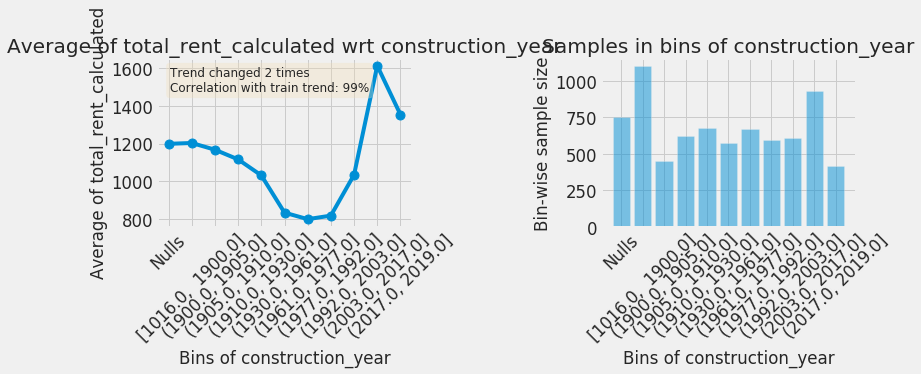

--------------------------------------------------------------------------------------------------------------


apartment_condition is categorical. Categorical features not supported yet.
heating_type is categorical. Categorical features not supported yet.
energy_certificate is categorical. Categorical features not supported yet.
                                     Plots for energy_consumption                                     
                                           Train data plots                                           


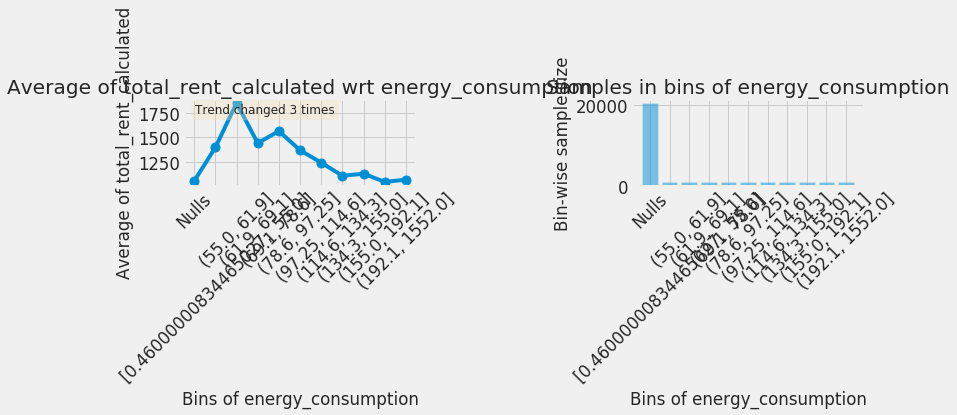

                                           Test data plots                                            


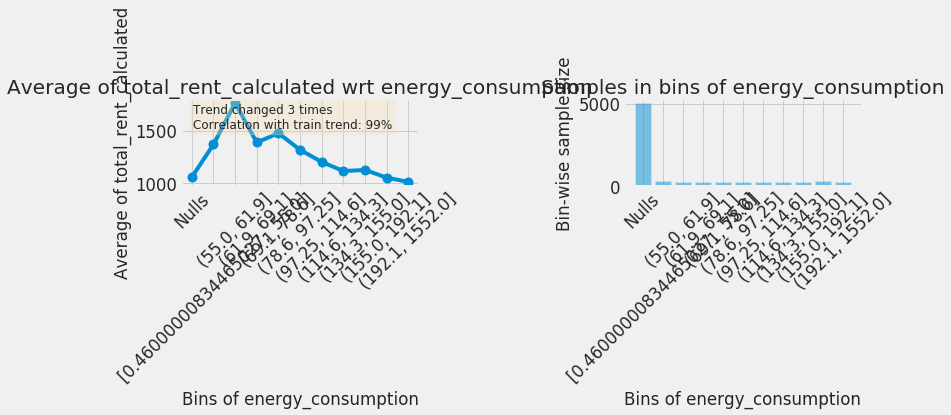

--------------------------------------------------------------------------------------------------------------


                                     Plots for has_amenity_balkon                                     
                                           Train data plots                                           


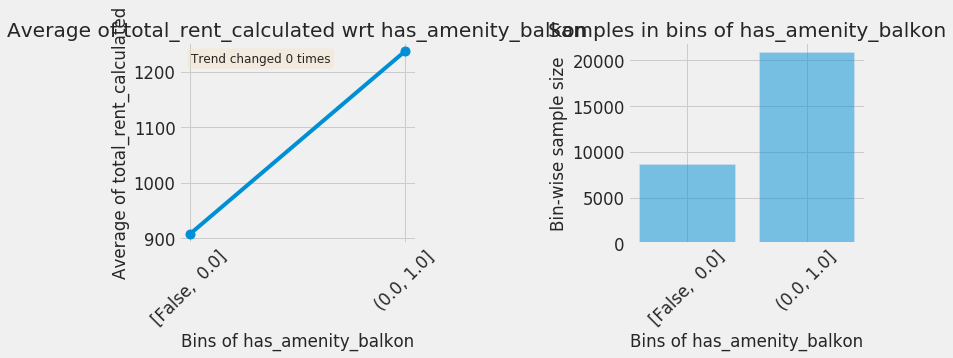

                                           Test data plots                                            


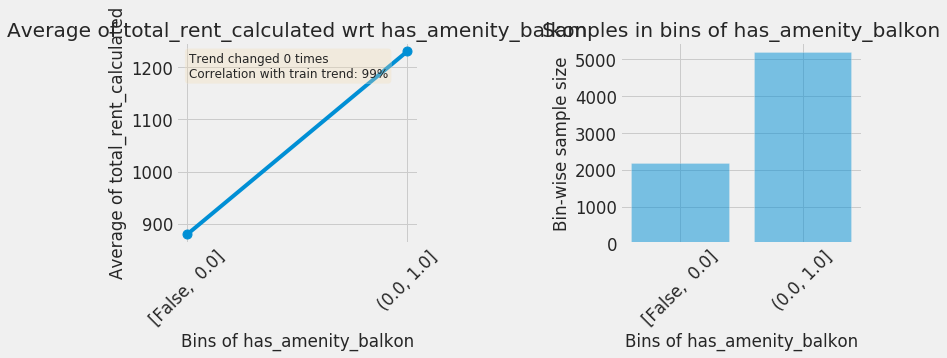

--------------------------------------------------------------------------------------------------------------


                                     Plots for has_amenity_keller                                     
                                           Train data plots                                           


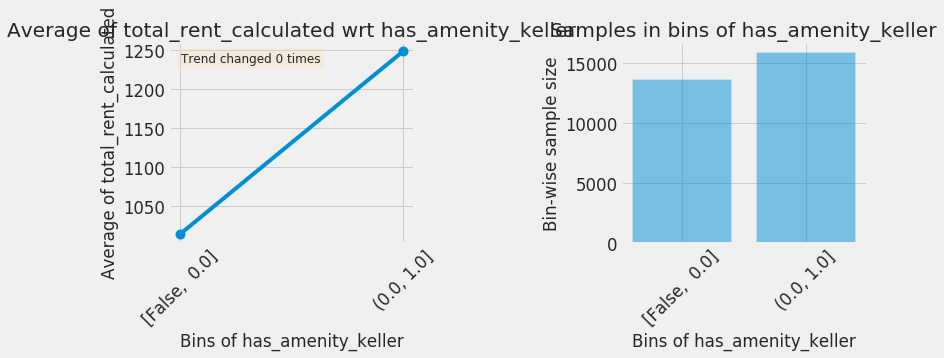

                                           Test data plots                                            


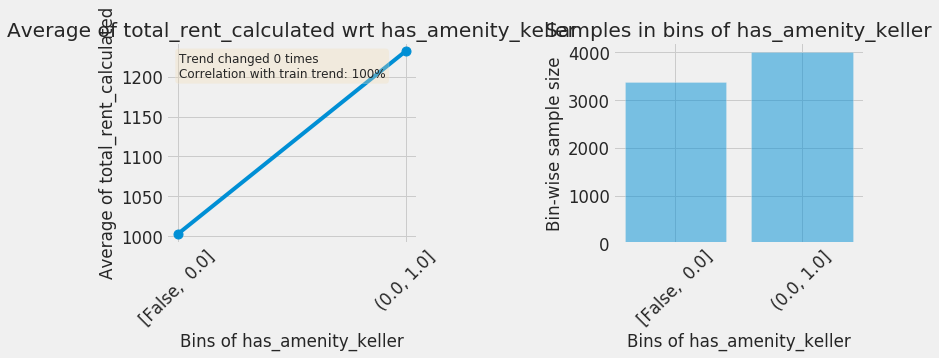

--------------------------------------------------------------------------------------------------------------


                                  Plots for has_amenity_einbauküche                                   
                                           Train data plots                                           


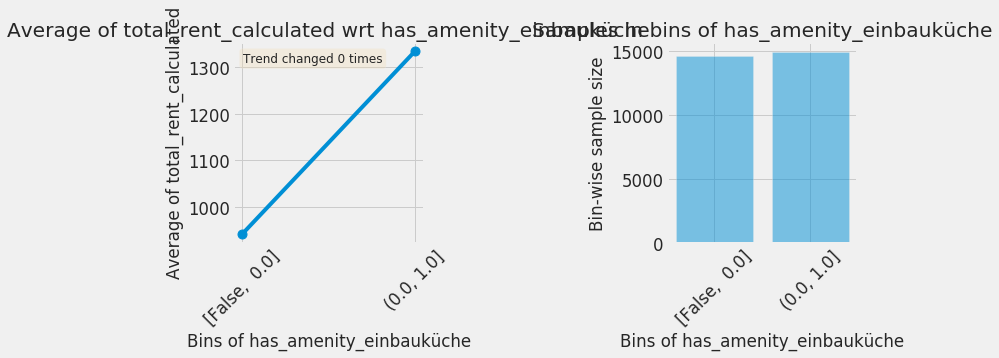

                                           Test data plots                                            


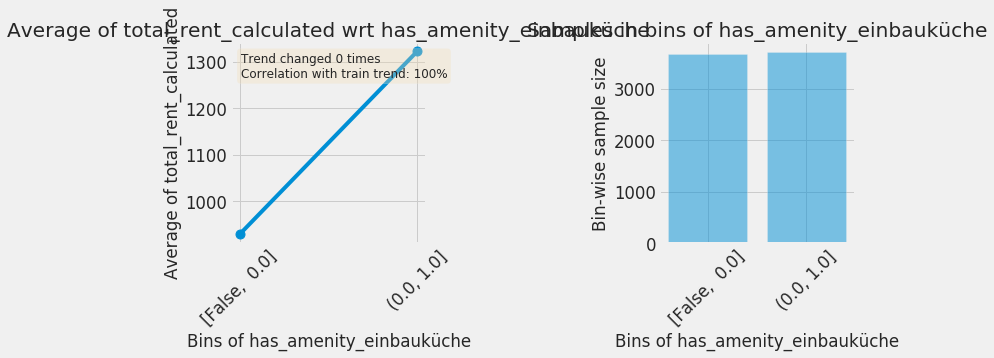

--------------------------------------------------------------------------------------------------------------


                                 Plots for has_amenity_personenaufzug                                 
                                           Train data plots                                           


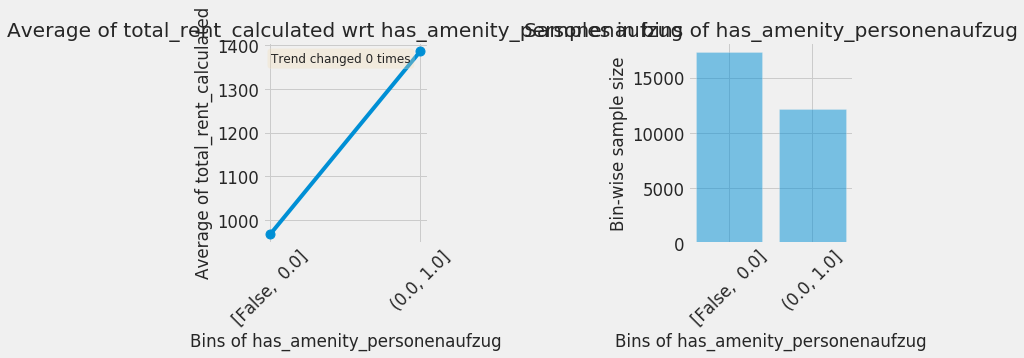

                                           Test data plots                                            


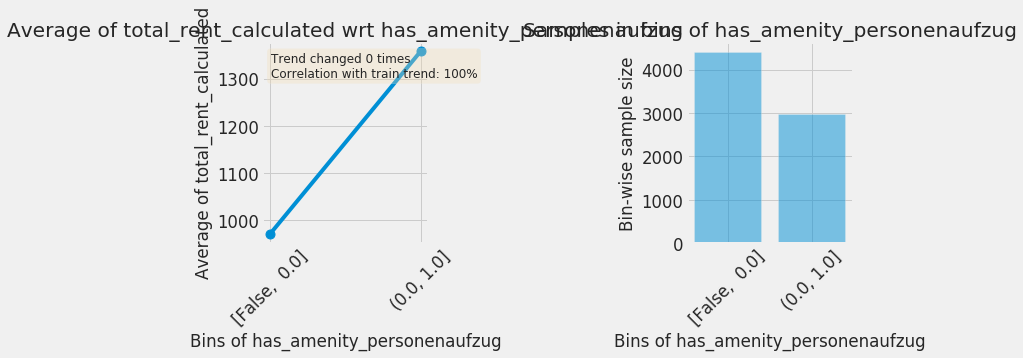

--------------------------------------------------------------------------------------------------------------


                                    Plots for has_amenity_gäste-wc                                    
                                           Train data plots                                           


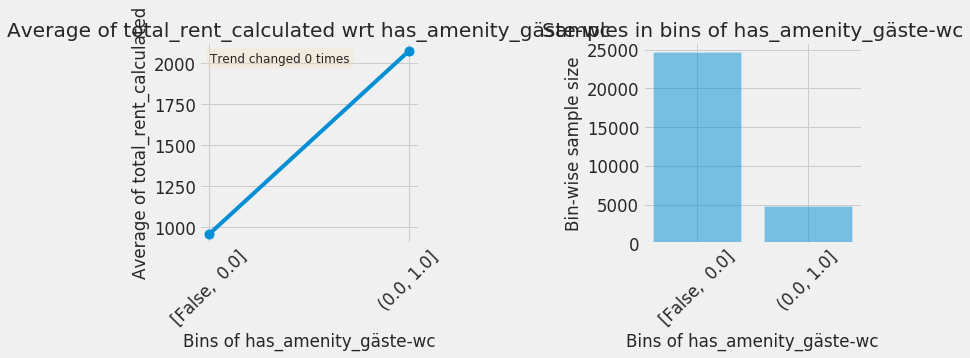

                                           Test data plots                                            


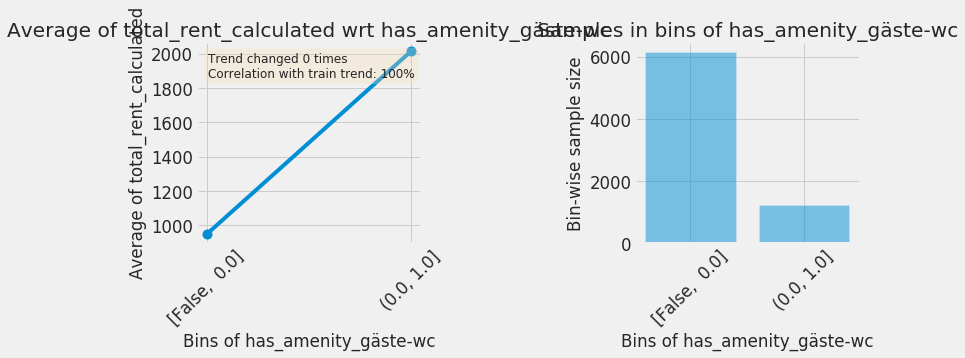

--------------------------------------------------------------------------------------------------------------


                                     Plots for has_amenity_garten                                     
                                           Train data plots                                           


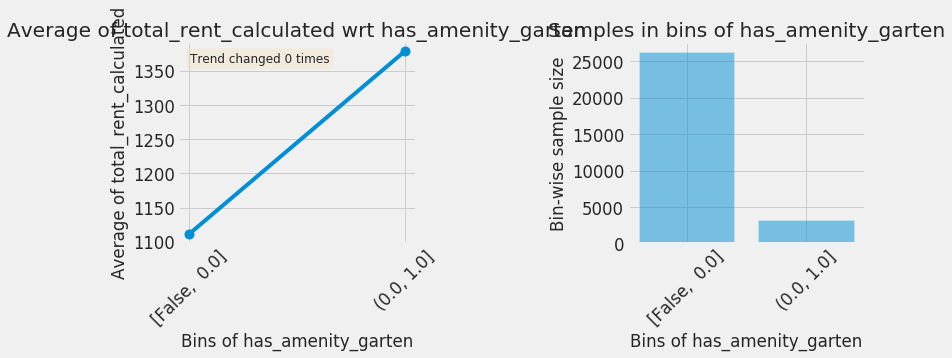

                                           Test data plots                                            


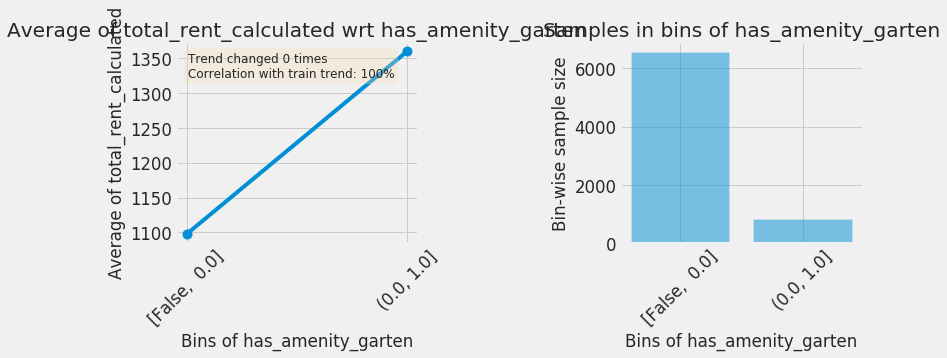

--------------------------------------------------------------------------------------------------------------


                                  Plots for has_amenity_wg-geeignet                                   
                                           Train data plots                                           


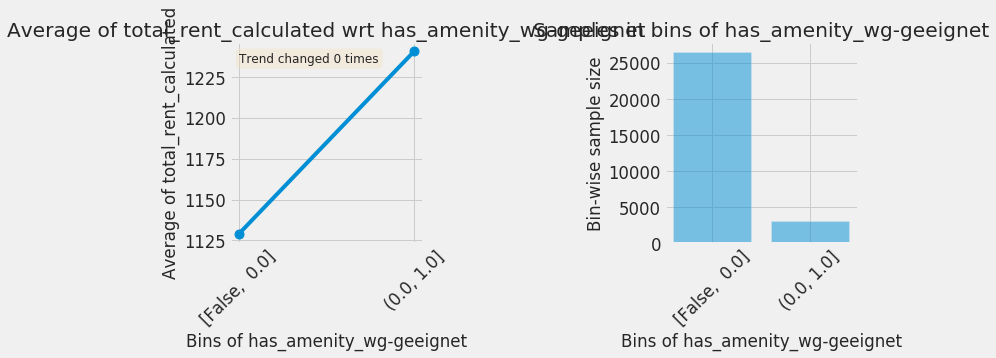

                                           Test data plots                                            


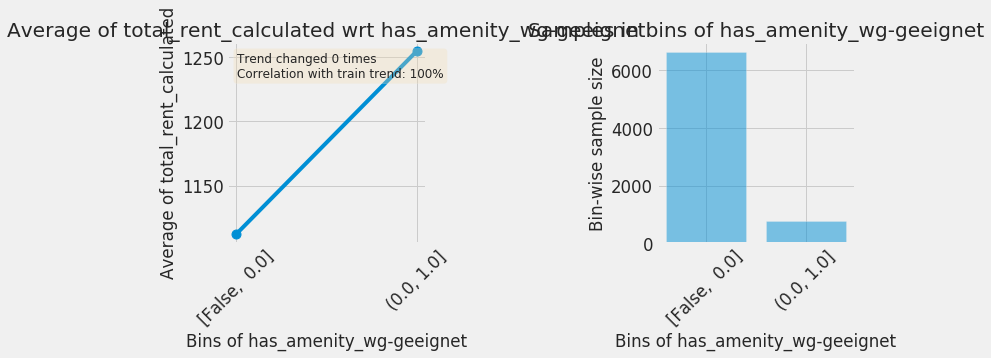

--------------------------------------------------------------------------------------------------------------


                                   Plots for has_amenity_stufenlos                                    
                                           Train data plots                                           


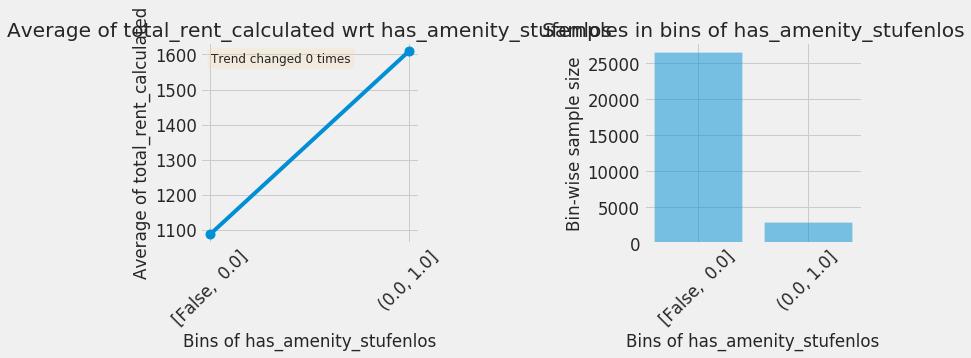

                                           Test data plots                                            


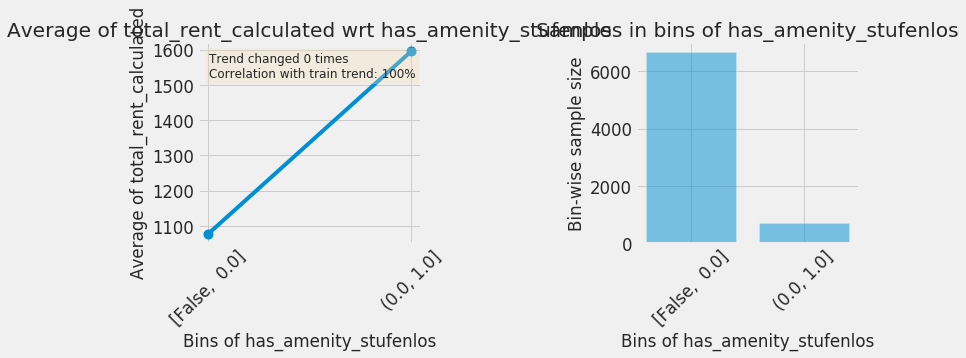

--------------------------------------------------------------------------------------------------------------


                            Plots for has_amenity_wohnberechtigungsschein                             
                                           Train data plots                                           


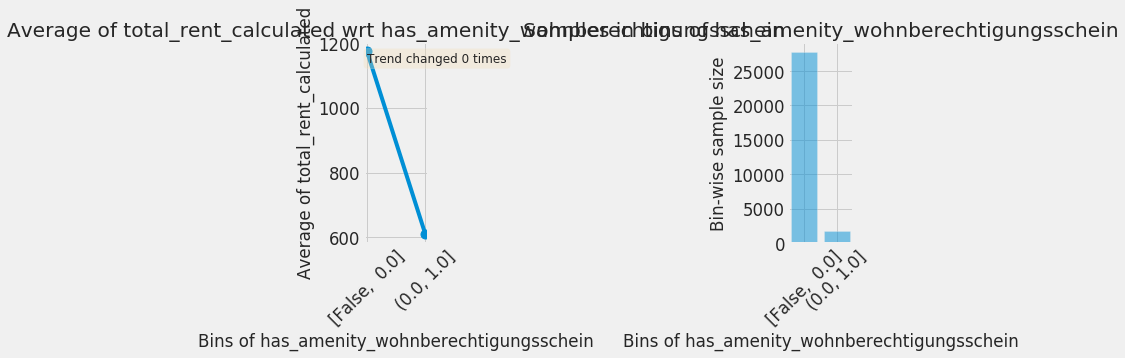

                                           Test data plots                                            


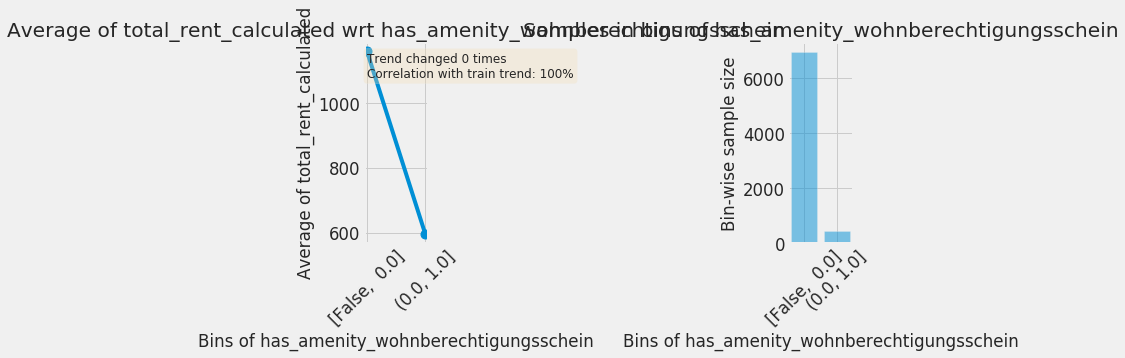

--------------------------------------------------------------------------------------------------------------


zipcode_clean is categorical. Categorical features not supported yet.
zipcode_clean_region is categorical. Categorical features not supported yet.
                                         Plots for offer_year                                         
                                           Train data plots                                           


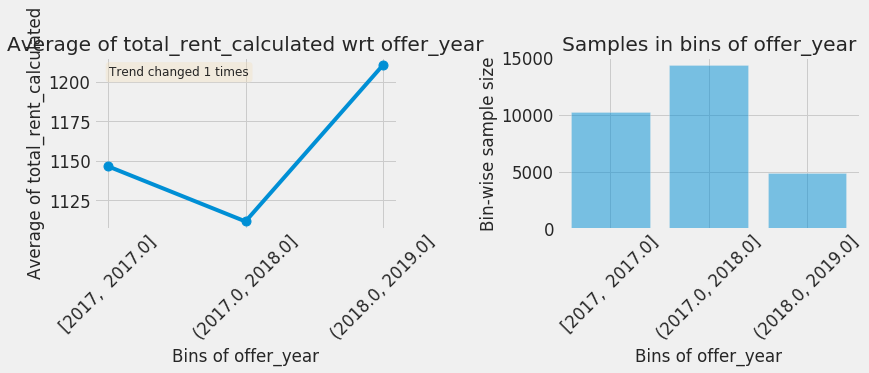

                                           Test data plots                                            


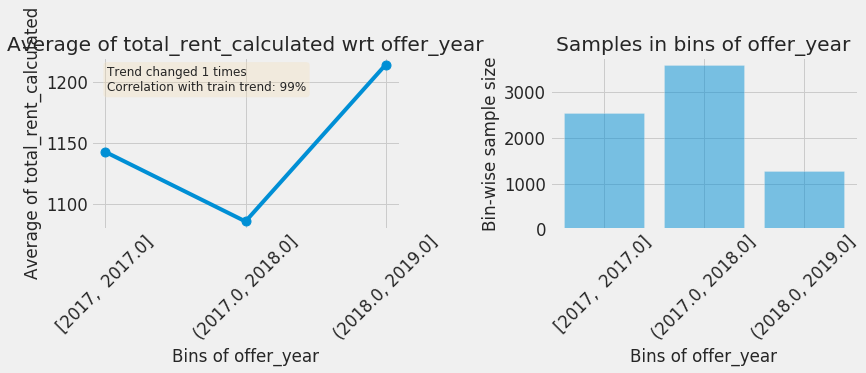

--------------------------------------------------------------------------------------------------------------


                                        Plots for offer_month                                         
                                           Train data plots                                           


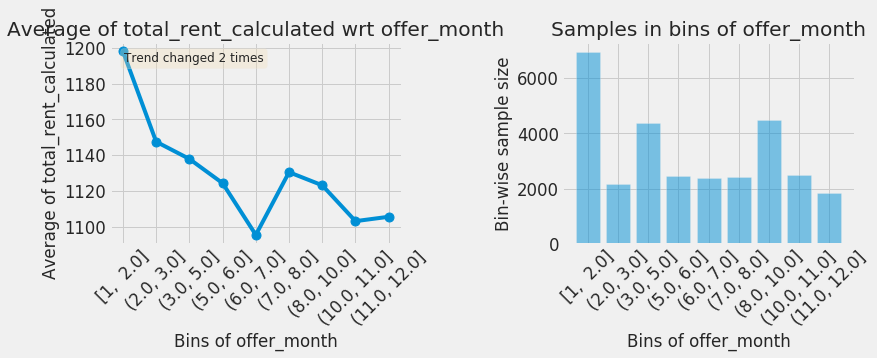

                                           Test data plots                                            


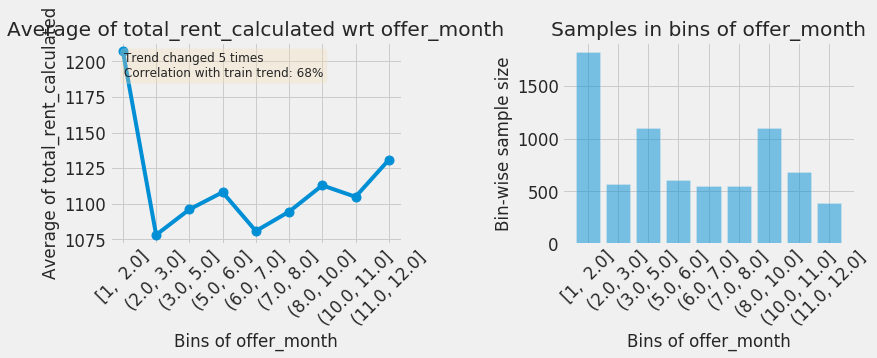

--------------------------------------------------------------------------------------------------------------


                                        Plots for ad_age_days                                         
                                           Train data plots                                           


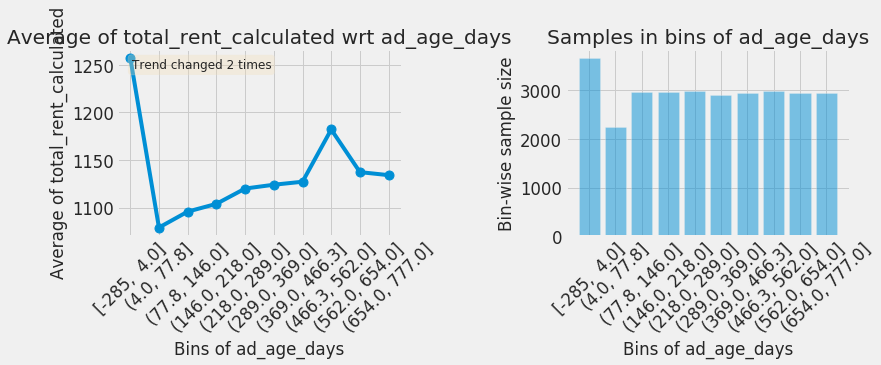

                                           Test data plots                                            


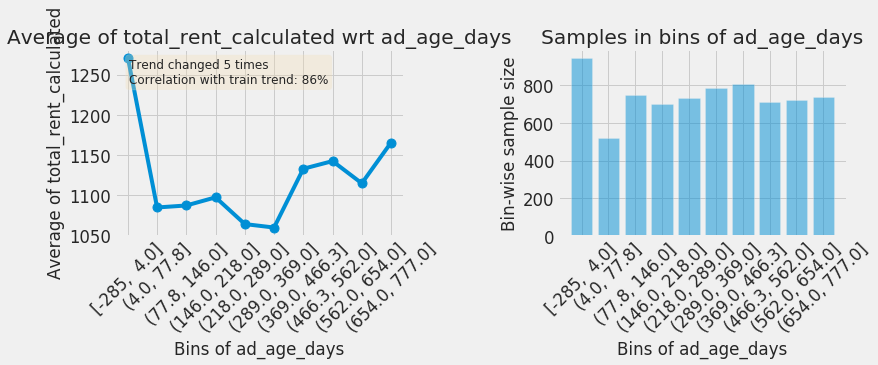

--------------------------------------------------------------------------------------------------------------


                                      Plots for house_age_years                                       
                                           Train data plots                                           


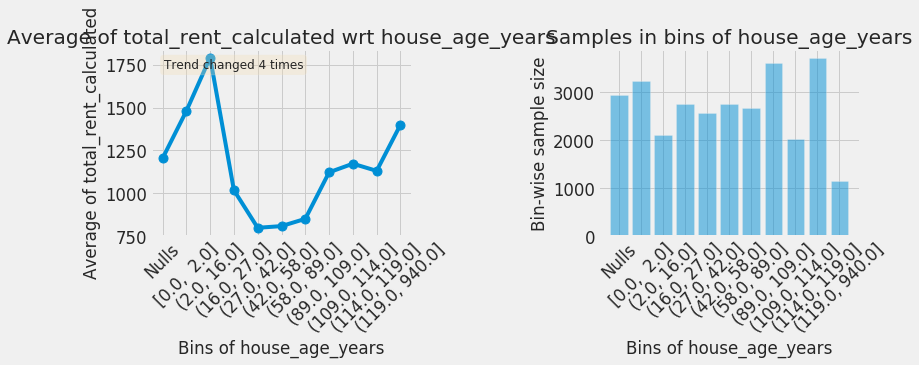

                                           Test data plots                                            


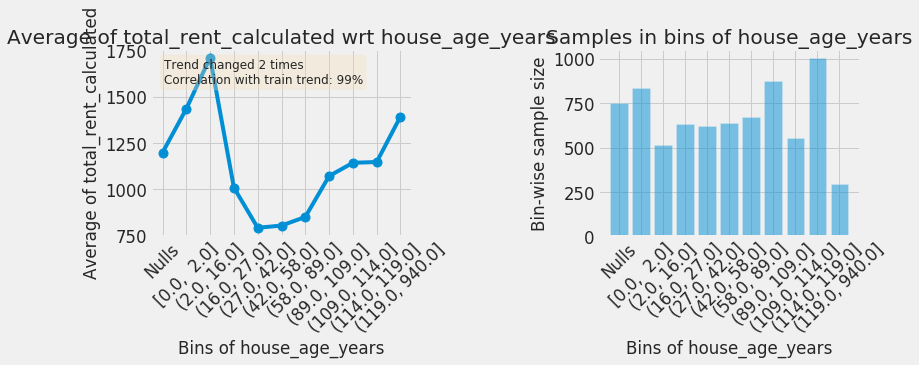

--------------------------------------------------------------------------------------------------------------


sub_district is categorical. Categorical features not supported yet.
district is categorical. Categorical features not supported yet.
floor_of_flat is categorical. Categorical features not supported yet.
total_floors_of_house is categorical. Categorical features not supported yet.


In [301]:
from featexp import univariate_plotter
from featexp import get_trend_stats
from featexp import get_univariate_plots


get_univariate_plots(data=X_train, target_col='total_rent_calculated', data_test=X_validation)

# data_test and features_list are optional. 
# Draws plots for all columns if features_list not passed
# Draws only train data plots if no test_data passed